# Pendahuluan
 Notebook ini berisi kode untuk membangun model klasifikasi gambar untuk mendeteksi penyakit tanaman menggunakan dataset PlantVillage.
 Dataset ini berisi gambar daun tanaman dengan berbagai kondisi (sehat atau terkena penyakit).
 Model yang digunakan adalah Convolutional Neural Network (CNN) berbasis arsitektur ResNet50 dengan teknik transfer learning.
 Kode ini mencakup langkah-langkah untuk memuat data, memproses gambar, melatih model, mengevaluasi performa, dan mengonversi model ke format TensorFlow.js.

# 1. Mengimpor Pustaka yang Diperlukan
 Bagian ini mengimpor pustaka-pustaka Python yang diperlukan untuk pemrosesan data, visualisasi, dan pembangunan model machine learning.

In [2]:
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

# 2. Memuat Dataset PlantVillage
 Fungsi ini digunakan untuk memuat dataset dari direktori PlantVillage dan membuat DataFrame yang berisi path file gambar dan labelnya.

In [8]:
import os
import pandas as pd

def load_dataset_from_directory(root_dir, dataset_prefix):
    """Membuat DataFrame dari struktur folder dataset dan menambahkan prefix pada label."""
    filepaths = []
    labels = []

    for label_name in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label_name)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                full_path = os.path.join(label_path, file_name)
                filepaths.append(full_path)
                labels.append(label_name)

    return pd.DataFrame({
        'Filepaths': filepaths,
        'Labels': labels
    })

# Path ke dataset PlantVillage
plantvillage_dir = '/kaggle/input/plantvillage-dataset/color'

# Muat dataset PlantVillage
df_plantvillage = load_dataset_from_directory(plantvillage_dir, 'plant')

# Tampilkan info singkat
print(f"Total sampel: {len(df_plantvillage)}")
print(f"Jumlah kelas unik: {df_plantvillage['Labels'].nunique()}")
df_plantvillage.head()

Total sampel: 54305
Jumlah kelas unik: 38


,Filepaths,Labels
0,/kaggle/input/plantvillage-dataset/color/Tomat...,Tomato___Late_blight
1,/kaggle/input/plantvillage-dataset/color/Tomat...,Tomato___Late_blight
2,/kaggle/input/plantvillage-dataset/color/Tomat...,Tomato___Late_blight
3,/kaggle/input/plantvillage-dataset/color/Tomat...,Tomato___Late_blight
4,/kaggle/input/plantvillage-dataset/color/Tomat...,Tomato___Late_blight


# 3. Menampilkan Distribusi Label
 Bagian ini menampilkan distribusi jumlah sampel per label (kelas) dalam dataset secara terurut berdasarkan abjad.

In [9]:
# Tampilkan distribusi label (urut abjad) dan jumlah label unik
label_counts = df_plantvillage['Labels'].value_counts().sort_index()

print("Distribusi label (urut abjad):")
print(label_counts)
print(f"\nJumlah label unik: {label_counts.shape[0]}")

Distribusi label (urut abjad):
Labels
Apple___Apple_scab                                     630
Apple___Black_rot                                      621
Apple___Cedar_apple_rust                               275
Apple___healthy                                       1645
Blueberry___healthy                                   1502
Cherry_(including_sour)___Powdery_mildew              1052
Cherry_(including_sour)___healthy                      854
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     513
Corn_(maize)___Common_rust_                           1192
Corn_(maize)___Northern_Leaf_Blight                    985
Corn_(maize)___healthy                                1162
Grape___Black_rot                                     1180
Grape___Esca_(Black_Measles)                          1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            1076
Grape___healthy                                        423
Orange___Haunglongbing_(Citrus_greening)              5507
Peach___Bacterial_

# 4. Memfilter Label yang Dipilih
 Dataset difilter untuk hanya menyertakan kelas-kelas tertentu yang relevan untuk analisis.

In [10]:
# Daftar label yang ingin disertakan
selected_labels = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]

# Filter dataframe berdasarkan label yang dipilih
df_plantvillage = df_plantvillage[df_plantvillage['Labels'].isin(selected_labels)].reset_index(drop=True)


# 5. Menampilkan Distribusi Label Setelah Filtering
 Menampilkan distribusi label setelah filtering untuk memastikan hanya kelas yang diinginkan yang tersisa.

In [11]:
# Tampilkan distribusi label (urut abjad) dan jumlah label unik
label_counts = df_plantvillage['Labels'].value_counts().sort_index()

print("Distribusi label (urut abjad):")
print(label_counts)
print(f"\nJumlah label unik: {label_counts.shape[0]}")

Distribusi label (urut abjad):
Labels
Apple___Apple_scab                                     630
Apple___Black_rot                                      621
Apple___Cedar_apple_rust                               275
Apple___healthy                                       1645
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     513
Corn_(maize)___Common_rust_                           1192
Corn_(maize)___Northern_Leaf_Blight                    985
Corn_(maize)___healthy                                1162
Grape___Black_rot                                     1180
Grape___Esca_(Black_Measles)                          1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            1076
Grape___healthy                                        423
Potato___Early_blight                                 1000
Potato___Late_blight                                  1000
Potato___healthy                                       152
Tomato___Bacterial_spot                               2127
Tomato___Early_bli

# 6. Membagi Dataset Menjadi Training, Validasi, dan Testing
 Dataset dibagi menjadi tiga subset: 80% untuk training, 10% untuk validasi, dan 10% untuk testing, dengan stratifikasi untuk menjaga proporsi kelas.

In [12]:
from sklearn.model_selection import train_test_split

# Pisahkan 80% untuk training, sisanya 20% untuk validasi + testing
train_df, temp_df = train_test_split(
    df_plantvillage,
    train_size=0.8,
    stratify=df_plantvillage['Labels'],  # pastikan proporsi kelas tetap
    shuffle=True,
    random_state=42
)

# Bagi sisa 20% menjadi 10% validasi dan 10% testing
valid_df, test_df = train_test_split(
    temp_df,
    train_size=0.5,
    stratify=temp_df['Labels'],
    shuffle=True,
    random_state=42
)

# Tampilkan jumlah data di setiap subset
print(f"Jumlah data training   : {len(train_df)}")
print(f"Jumlah data validasi   : {len(valid_df)}")
print(f"Jumlah data testing    : {len(test_df)}")

# Cek distribusi label sesuai abjad
print("\nDistribusi label di data training (urut abjad):")
print(train_df['Labels'].value_counts().sort_index())

Jumlah data training   : 25117
Jumlah data validasi   : 3140
Jumlah data testing    : 3140

Distribusi label di data training (urut abjad):
Labels
Apple___Apple_scab                                     504
Apple___Black_rot                                      497
Apple___Cedar_apple_rust                               220
Apple___healthy                                       1316
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     410
Corn_(maize)___Common_rust_                            954
Corn_(maize)___Northern_Leaf_Blight                    788
Corn_(maize)___healthy                                 930
Grape___Black_rot                                      944
Grape___Esca_(Black_Measles)                          1106
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)             861
Grape___healthy                                        338
Potato___Early_blight                                  800
Potato___Late_blight                                   800
Potato___healthy           

# 7. Membuat Generator Data untuk Augmentasi dan Pemrosesan Gambar
 ImageDataGenerator digunakan untuk augmentasi data (training) dan normalisasi gambar (validasi dan testing).

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 25117 validated image filenames belonging to 25 classes.
Found 3140 validated image filenames belonging to 25 classes.
Found 3140 validated image filenames belonging to 25 classes.


# 8. Menampilkan Contoh Gambar dari Dataset
 Fungsi ini menampilkan beberapa gambar acak dari dataset training untuk memberikan gambaran visual tentang data.

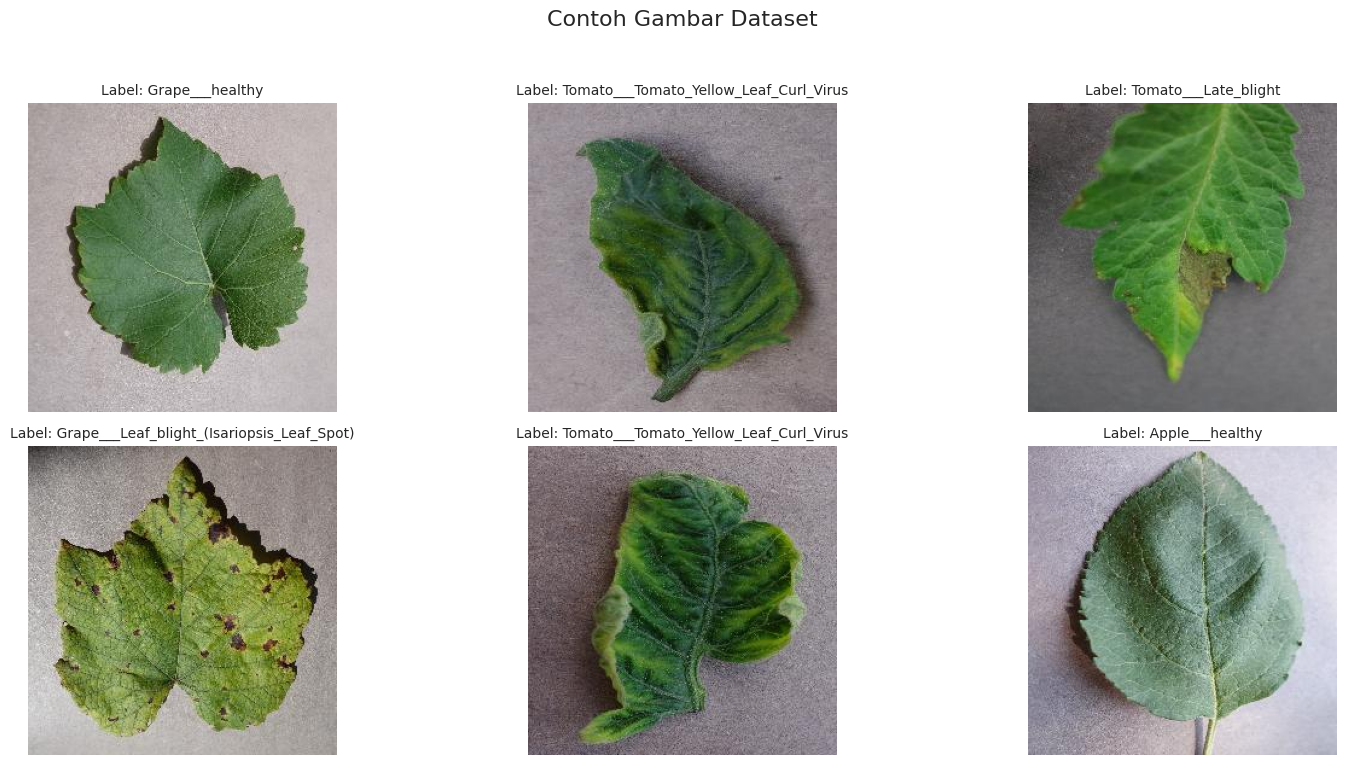

In [ ]:
import matplotlib.pyplot as plt
import random
from matplotlib.image import imread

def plot_random_samples(df, num_samples=6, title='Contoh Gambar Dataset'):
    """Menampilkan sejumlah gambar acak dari DataFrame berisi path dan label gambar."""
    plt.figure(figsize=(16, 8))

    samples = df.sample(n=num_samples, random_state=random.randint(1, 9999)).reset_index(drop=True)

    for idx, row in samples.iterrows():
        img = imread(row['Filepaths'])
        label = row['Labels']

        plt.subplot(2, (num_samples + 1) // 2, idx + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}', fontsize=10)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Contoh penggunaan
plot_random_samples(train_df, num_samples=6)


# 9. Mendefinisikan Callback untuk Pelatihan Model
 Callback digunakan untuk mengontrol pelatihan model, seperti menghentikan pelatihan jika tidak ada peningkatan atau menyimpan model terbaik.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Path untuk menyimpan model dan log
model_path = '/kaggle/working/model.keras'
log_file = '/kaggle/working/training_log.log'

# Daftar callback
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,  # Simpan model utuh (.keras)
        verbose=1
    ),
    CSVLogger(log_file)  # Menyimpan log training ke file .log
]

# 10. Membangun Model ResNet50 dengan Transfer Learning
 Model menggunakan arsitektur ResNet50 yang telah dilatih sebelumnya (pre-trained) pada dataset ImageNet, dengan lapisan tambahan untuk klasifikasi.

In [17]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_base.layers:
    layer.trainable = True

model = keras.Sequential([
    Input(shape=(224, 224, 3)),
    resnet_base,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(25, activation='softmax')
])


model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,119,705 (92.01 MB)

 Trainable params: 24,066,073 (91.80 MB)

 Non-trainable params: 53,632 (209.50 KB)

# 11. Melatih Model
 Model dilatih menggunakan data training dan divalidasi menggunakan data validasi, dengan callback untuk mengontrol pelatihan.

In [18]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1749654198.539592     103 service.cc:148] XLA service 0x78e6c0007420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749654198.540504     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749654202.397174     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/785 ━━━━━━━━━━━━━━━━━━━━ 15:06:57 69s/step - accuracy: 0.0312 - loss: 4.9214

I0000 00:00:1749654222.047394     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7585 - loss: 0.8638
Epoch 1: val_accuracy improved from -inf to 0.16561, saving model to /kaggle/working/model.keras
785/785 ━━━━━━━━━━━━━━━━━━━━ 509s 561ms/step - accuracy: 0.7586 - loss: 0.8633 - val_accuracy: 0.1656 - val_loss: 5.7045 - learning_rate: 0.0010
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9433 - loss: 0.1809
Epoch 2: val_accuracy improved from 0.16561 to 0.79841, saving model to /kaggle/working/model.keras
785/785 ━━━━━━━━━━━━━━━━━━━━ 309s 393ms/step - accuracy: 0.9433 - loss: 0.1809 - val_accuracy: 0.7984 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9552 - loss: 0.1397
Epoch 3: val_accuracy improved from 0.79841 to 0.93567, saving model to /kaggle/working/model.keras
785/785 ━━━━━━━━━━━━━━━━━━━━ 307s 391ms/step - accuracy: 0.9552 - loss: 0.1397 - val_accuracy: 0.9357 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 4/10
785/

# 12. Mengevaluasi Model pada Data Testing
 Model dievaluasi pada data testing untuk mendapatkan akurasi dan loss.

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9975 - loss: 0.0126
Test Accuracy: 0.9949044585227966


# 13. Membuat Prediksi dan Visualisasi Hasil
 Model digunakan untuk memprediksi kelas pada data testing, kemudian hasilnya divisualisasikan menggunakan confusion matrix dan classification report.

In [20]:
pred_probs = model.predict(test_generator, verbose=1)

y_pred = np.argmax(pred_probs, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step


# 14. Visualisasi Performa Pelatihan
 Grafik loss dan akurasi untuk data training dan validasi divisualisasikan untuk memahami performa model selama pelatihan.

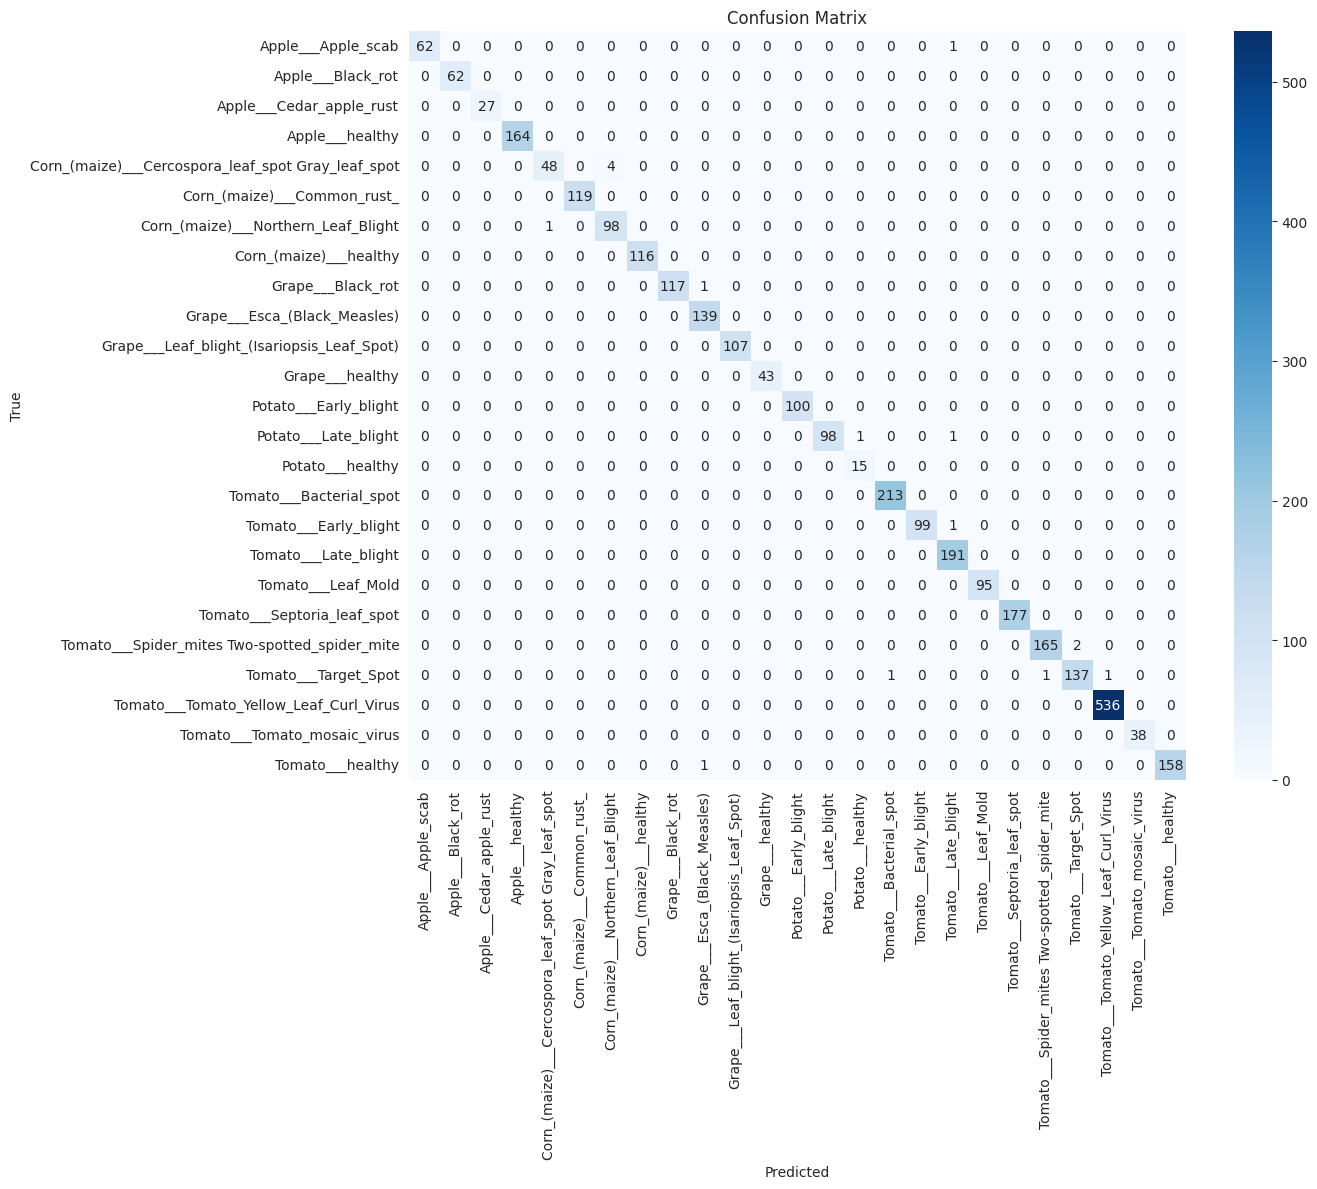

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.98      0.99        63
                                 Apple___Black_rot       1.00      1.00      1.00        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       1.00      1.00      1.00       164
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.92      0.95        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
               Corn_(maize)___Northern_Leaf_Blight       0.96      0.99      0.98        99
                            Corn_(maize)___healthy       1.00      1.00      1.00       116
                                 Grape___Black_rot       1.00      0.99      1.00       118
                      Grape___Esca_(Black_Measles)     

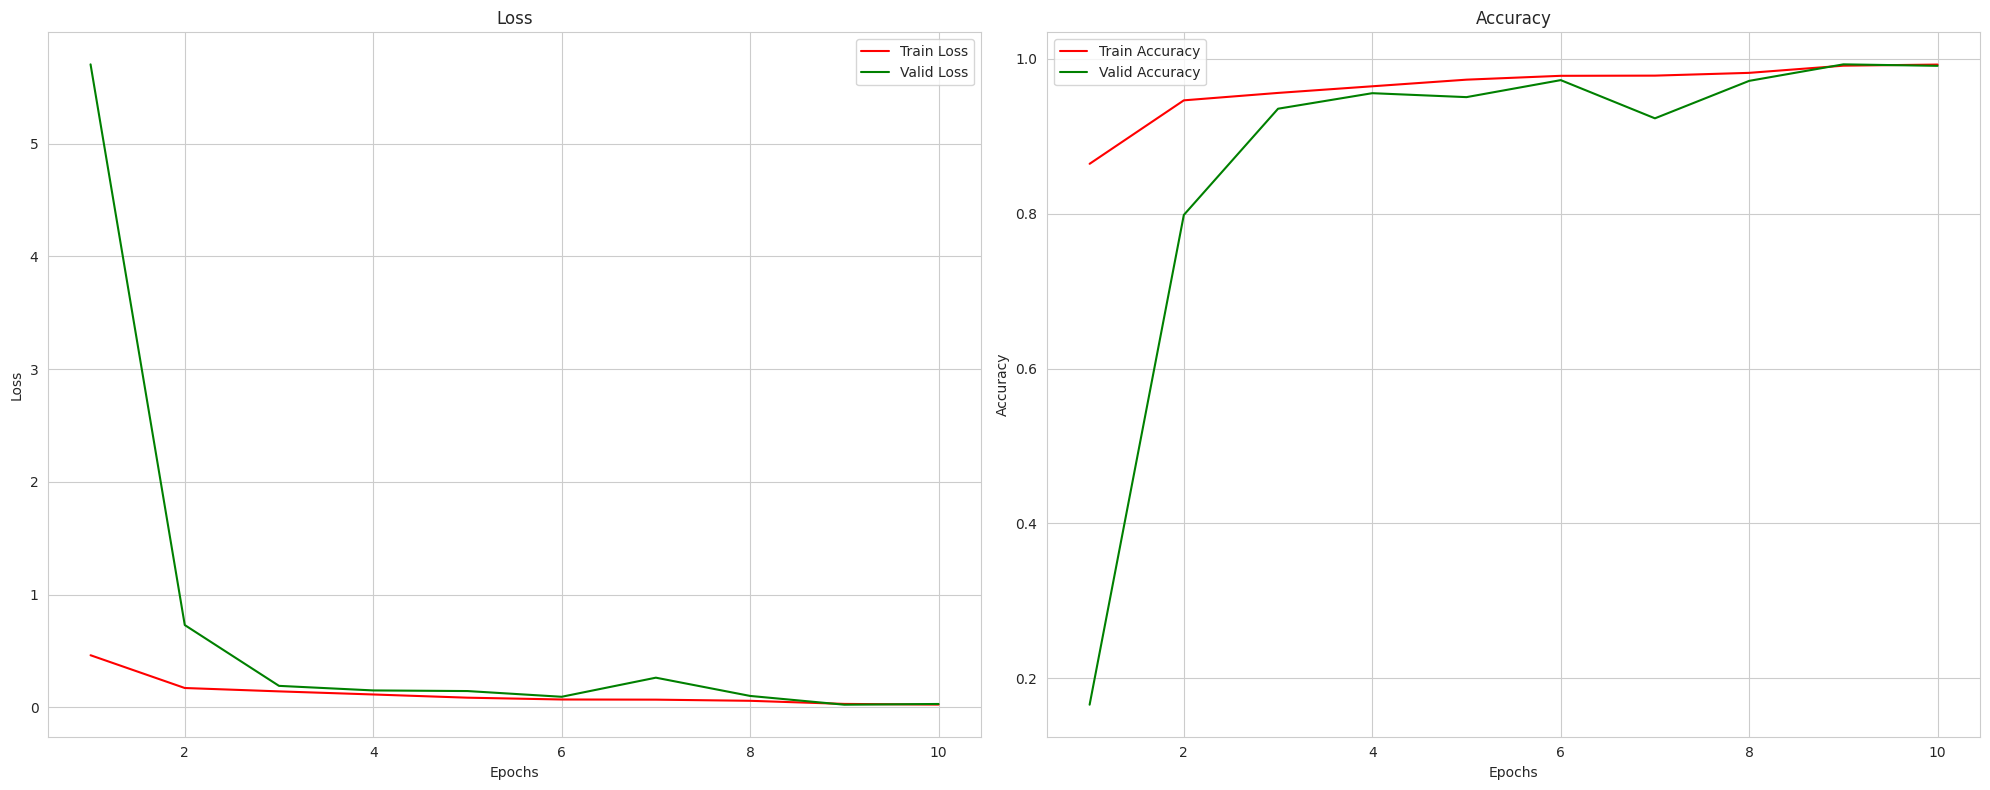

In [23]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 15. Menyimpan Model dalam Format SavedModel
 Model disimpan dalam format TensorFlow SavedModel untuk penggunaan lebih lanjut.

In [24]:
import tensorflow as tf

tf.saved_model.save(model, '/kaggle/working/saved_model_format')

# 16. Mengonversi Model ke Format TensorFlow.js
 Model dikonversi ke format TensorFlow.js agar dapat digunakan dalam aplikasi berbasis web.

In [25]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /kaggle/working/saved_model_format \
    /kaggle/working/tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 108.2 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is inc